# 데이터 소개

캐글 [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance/data)

의료비 개인 데이터 세트

#0.기본세팅

In [21]:
# 라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn : 전처리, 모델 학습/평가
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

# xgboost : 고성능 모델
import xgboost as xgb

# shap : 모델 해석 (XAI, 설명가능한 AI)
import shap

In [17]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# 파일 불러오기
df = pd.read_csv("/content/drive/MyDrive/분석/Medical Cost Personal/insurance.csv")

In [19]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ① 설치된 나눔고딕 파일 경로 (코랩 기본 위치)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# ② Matplotlib 폰트 매니저에 파일을 직접 등록
fm.fontManager.addfont(font_path)

# ③ 파일에서 실제 폰트 '이름' 가져와 rcParams에 지정
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("사용 중인 폰트:", mpl.rcParams['font.family'])

사용 중인 폰트: ['NanumGothic']


#1.EDA (탐색적 분석)

In [44]:
# MCP변수에 저장
MCP = df.copy()

In [41]:
MCP.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [24]:
MCP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [25]:
MCP.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [26]:
MCP.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


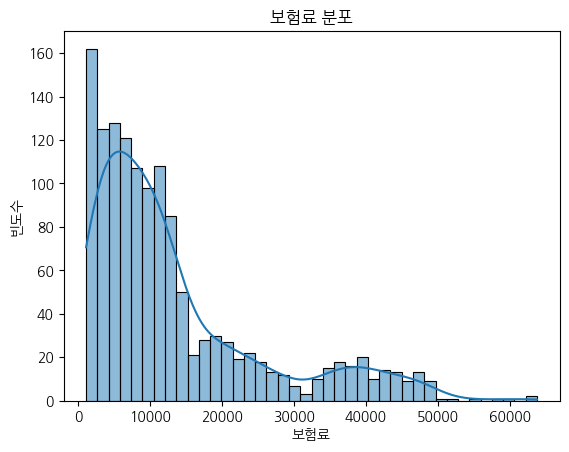

In [45]:
# 보험료 분포 확인
sns.histplot(MCP["charges"], bins=40, kde=True)
plt.title("보험료 분포")
plt.xlabel("보험료")
plt.ylabel("빈도수")
plt.show()

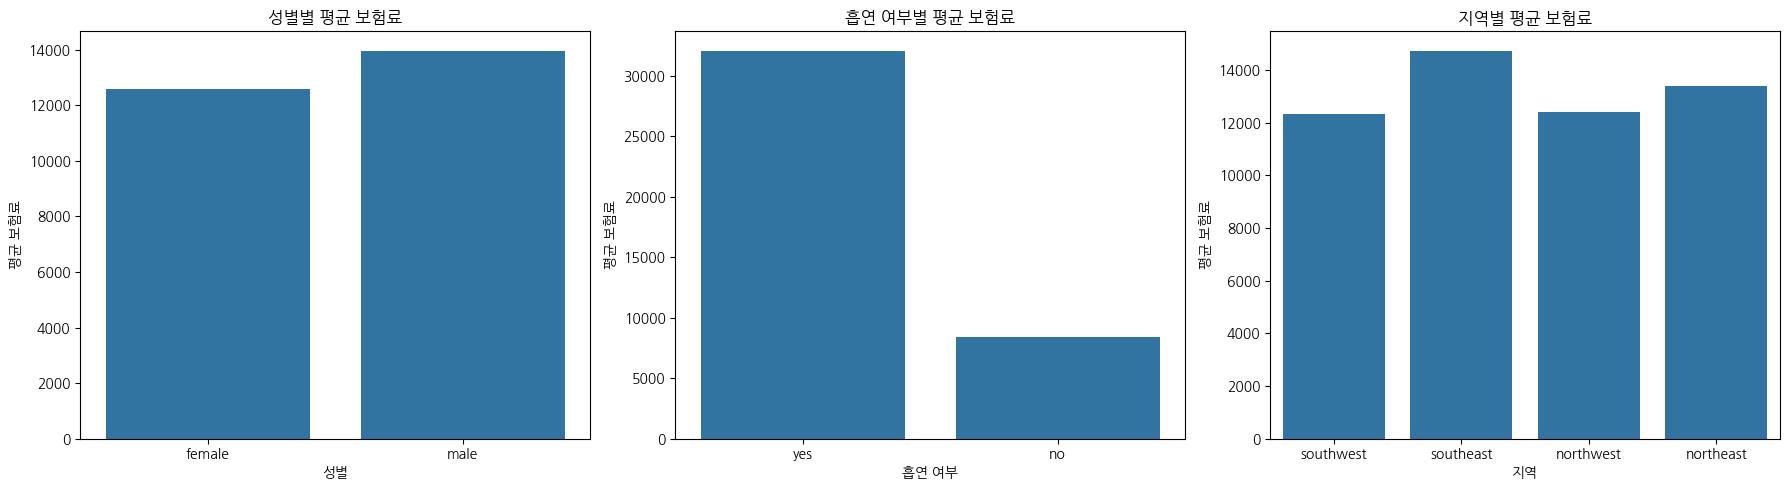

In [46]:
# 범주형- 변수별 평균 보험료

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cols = ["sex", "smoker", "region"]
korean_labels = {"sex":"성별", "smoker":"흡연 여부", "region":"지역"}

for i, col in enumerate(cols):
    sns.barplot(x=col, y="charges", data=MCP, estimator=np.mean, errorbar=None, ax=axes[i])
    axes[i].set_title(f"{korean_labels[col]}별 평균 보험료")
    axes[i].set_xlabel(korean_labels[col])
    axes[i].set_ylabel("평균 보험료")

plt.tight_layout()
plt.show()

In [47]:
# 파생 변수 추가 (보험 리스크 반영)

def add_features(data):
    out = data.copy()

    # 나이 구간
    out["연령대"] = pd.cut(out["age"],
                          bins=[0,25,35,45,55,120],
                          labels=["≤25세","26-35세","36-45세","46-55세","≥56세"])

    # BMI 구간 (한국 기준)
    out["BMI구간"] = pd.cut(out["bmi"],
                           bins=[0,18.5,23,25,100],

                           labels=["저체중","정상","과체중","비만"])
    # 흡연 여부 플래그
    out["흡연자여부"] = (out["smoker"]=="yes").astype(int)

    # 상호작용 변수
    out["나이×흡연"] = out["age"] * out["흡연자여부"]
    out["BMI×흡연"] = out["bmi"] * out["흡연자여부"]
    return out

MCP = add_features(MCP)
MCP.head()

,age,sex,bmi,children,smoker,region,charges,연령대,BMI구간,흡연자여부,나이×흡연,BMI×흡연
0,19,female,27.900,0,yes,southwest,16884.92400,≤25세,비만,1,19,27.9
1,18,male,33.770,1,no,southeast,1725.55230,≤25세,비만,0,0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,26-35세,비만,0,0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,26-35세,정상,0,0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,26-35세,비만,0,0,0.0


#2.모델링 & 성능비교

In [48]:
# 학습/평가 데이터 분리
TARGET = "charges"

# 숫자형 + 범주형 변수
num_cols = ["age","bmi","children","나이×흡연","BMI×흡연"]
cat_cols = ["sex","smoker","region","연령대","BMI구간"]

X = MCP[num_cols + cat_cols]
y = MCP[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 전처리 파이프라인
preprocess = ColumnTransformer([
    ("수치형", StandardScaler(), num_cols),
    ("범주형", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [49]:
# 모델 비교 (교차검증)

def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "선형회귀": Pipeline([("전처리", preprocess), ("모델", LinearRegression())]),
    "Lasso": Pipeline([("전처리", preprocess), ("모델", Lasso(alpha=0.001, max_iter=20000))]),
    "랜덤포레스트": Pipeline([("전처리", preprocess), ("모델", RandomForestRegressor(n_estimators=500, random_state=42))]),
    "XGBoost": Pipeline([("전처리", preprocess), ("모델", xgb.XGBRegressor(
        n_estimators=500, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))])
}

results = []
for name, pipe in models.items():
    mae = -cross_val_score(pipe, X_train, y_train, scoring="neg_mean_absolute_error", cv=cv).mean()
    rmse_val = -cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv).mean()
    results.append({"모델": name, "CV_MAE": mae, "CV_RMSE": rmse_val})

pd.DataFrame(results).sort_values("CV_RMSE")

,모델,CV_MAE,CV_RMSE
2,랜덤포레스트,2764.035861,4864.966638
1,Lasso,2980.612566,4882.217865
0,선형회귀,2980.612728,4882.219204
3,XGBoost,2925.519020,5018.558102


CV_MAE (Mean Absolute Error) : 오차의 절대값 평균

CV_RMSE (Root Mean Squared Error) : 제곱근 평균제곱오차

→ 두 지표 다 작을수록 예측이 실제와 가까움

평균 절대 오차(MAE): 2499.014707864714
평균 제곱근 오차(RMSE): 4545.580314067091
결정계수(R²): 0.8669084108250562


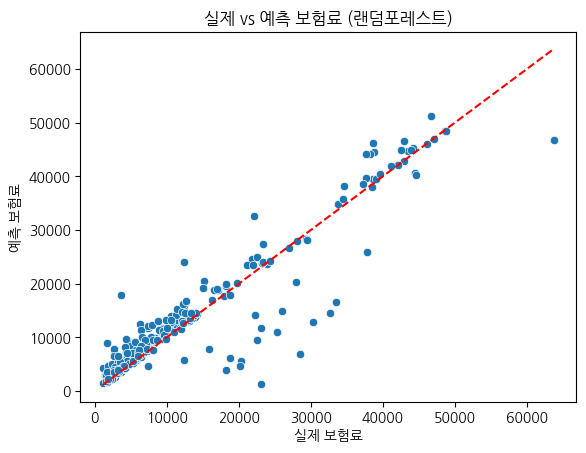

In [51]:
best_model = models["랜덤포레스트"]
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

print("평균 절대 오차(MAE):", mean_absolute_error(y_test, pred))
print("평균 제곱근 오차(RMSE):", rmse(y_test, pred))
print("결정계수(R²):", r2_score(y_test, pred))

# 실제값 vs 예측값 시각화
sns.scatterplot(x=y_test, y=pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("실제 보험료")
plt.ylabel("예측 보험료")
plt.title("실제 vs 예측 보험료 (랜덤포레스트)")
plt.show()

MAE (평균 절대 오차) : 약 2,499
→ 실제 보험료와 예측 보험료의 평균 차이가 2,500달러 내외로 작음

RMSE (평균 제곱근 오차) : 약 4,546
→ 큰 오차에도 안정적인 예측력을 보임

R² (결정계수) : 0.867 (86.7%)
→ 모델이 전체 보험료 변동성의 약 87%를 설명

#3.모델 해석

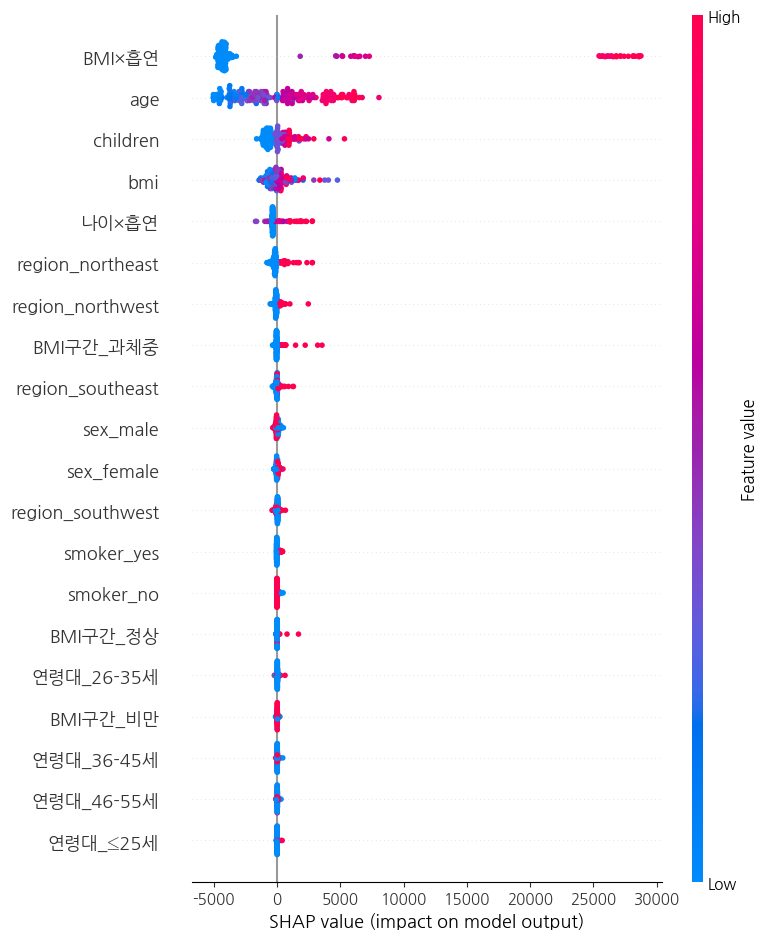

In [52]:
# SHAP 해석
onehot = best_model.named_steps["전처리"].named_transformers_["범주형"]
ohe_names = list(onehot.get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_names

X_train_trans = best_model.named_steps["전처리"].fit_transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps["모델"])
shap_values = explainer.shap_values(X_train_trans[:200])

shap.summary_plot(shap_values, X_train_trans[:200], feature_names=feature_names)

1. BMI x 흡연 (가장 영향력 큼) -> BMI가 높고 흡연자인 경우 보험료가 급격히 올라감
2. age (나이) -> 나이가 많을수록 보험료 ↑, 고령층일수록 위험 반영
3. children (자녀 수) -> 자녀 수가 많을수록 보험료 상승 경향
4. bmi (체질량지수) -> BMI가 높을수록 보험료 ↑ , 건강검진/비만 관리 프로그램과 연계 가능
5. 나이 x 흡연 (상호작용) -> 특히 고령 흡연자의 경우 보험료가 크게 상승

#4.비즈니스 인사이트

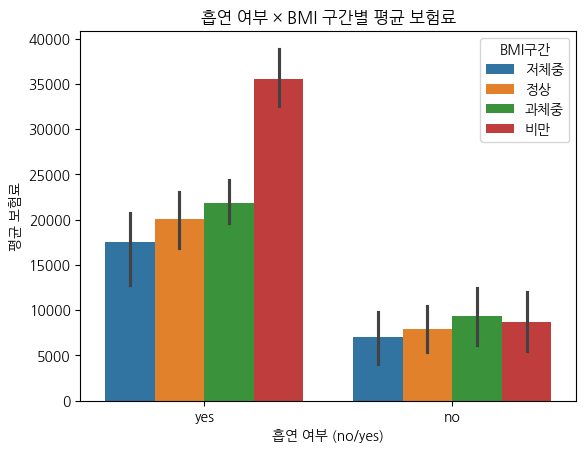

In [53]:
# 비즈니스 인사이트

biz_table = MCP.groupby(["smoker","BMI구간","연령대"])["charges"].mean().reset_index()
biz_table = biz_table.sort_values("charges", ascending=False)

# 상위 위험 그룹 확인
biz_table.head(10)

# 시각화
sns.barplot(data=biz_table, x="smoker", y="charges", hue="BMI구간")
plt.title("흡연 여부 × BMI 구간별 평균 보험료")
plt.xlabel("흡연 여부 (no/yes)")
plt.ylabel("평균 보험료")
plt.show()